In [8]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import os


# Try mtcnn  
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/


In [4]:

def open_image_resize(filename):
    img = Image.open(filename)
    img = img.resize((160,160))
    npi = np.asarray(img)
    print(npi.shape)
    img.close()
    npi = npi.reshape(1,160,160,3)
    return npi.copy()

imgf1  = 'cofund_1_bsaldivar.png'
imgf2  = 'cofund_2_bsaldivar.png'


In [5]:
import mtcnn
# print version
print(mtcnn.__version__)

0.0.9


In [32]:
filename = 'bsaldivar_cofund_torso.png'
filename = 'test_1024x685.png'
filename = 'bryan_saldivar_1552908771_280.jpg'
pixels = plt.imread(filename)
print(type(pixels),pixels.shape)
#pixels = pixels[:,:,:3]

<class 'numpy.ndarray'> (373, 280, 3)


In [34]:
from mtcnn.mtcnn import MTCNN
# load image from file

# create the detector, using default weights
detector = MTCNN(min_face_size=20)
# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
    print(face)

{'confidence': 0.9999853372573853, 'keypoints': {'mouth_right': (229, 129), 'left_eye': (201, 94), 'nose': (211, 109), 'mouth_left': (211, 133), 'right_eye': (226, 90)}, 'box': [181, 57, 74, 97]}


In [92]:
image_dir = 'cofunds/frontal/'
cofunds = os.listdir(image_dir)
images_files = list(map(lambda x: image_dir+x,cofunds))


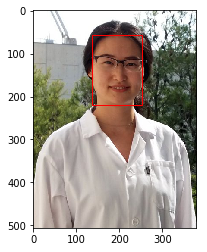

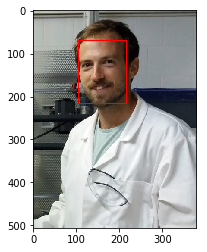

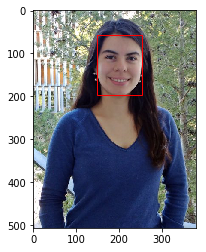

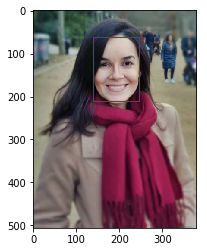

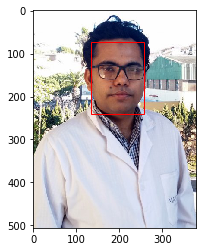

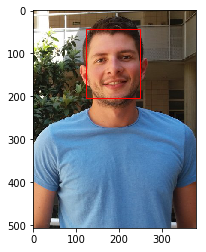

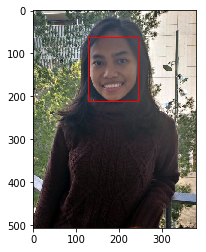

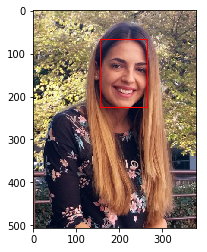

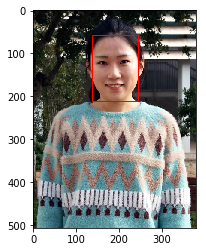

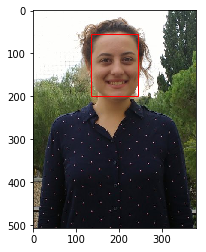

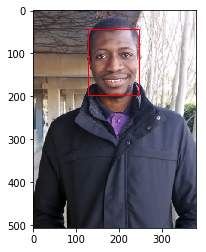

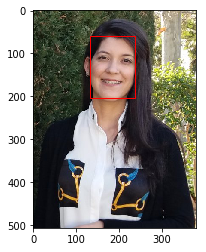

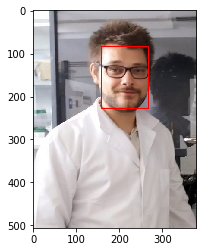

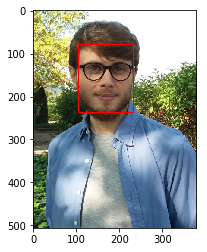

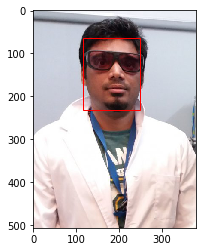

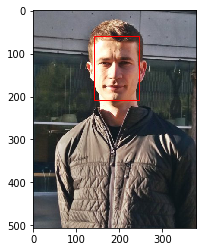

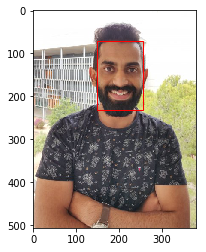

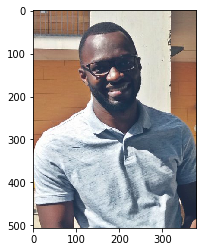

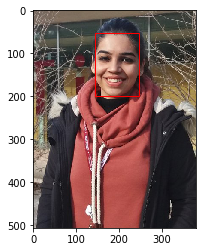

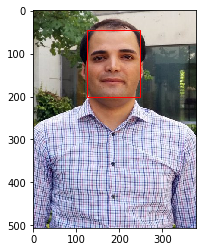

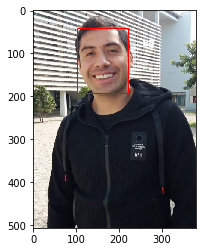

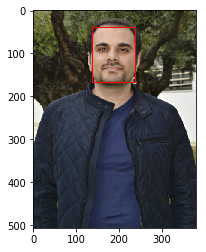

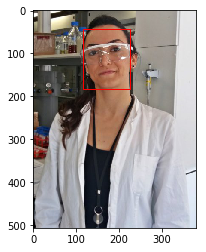

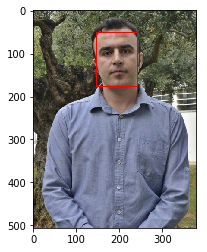

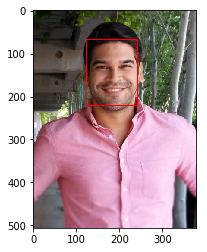

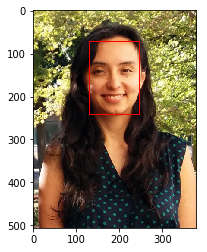

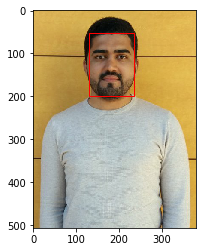

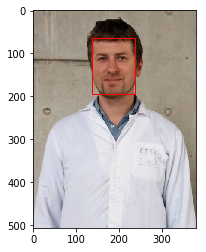

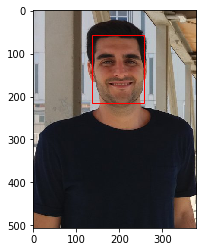

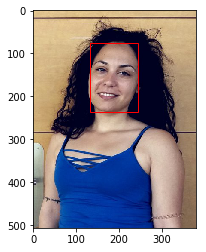

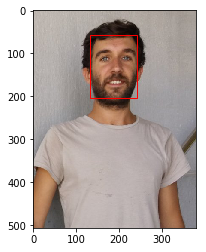

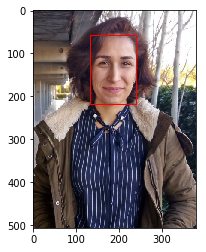

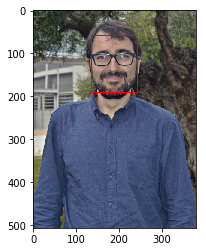

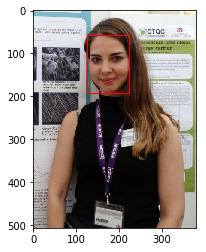

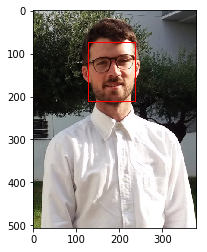

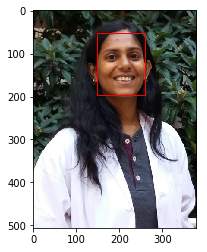

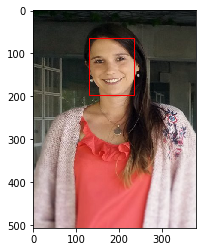

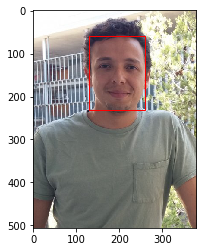

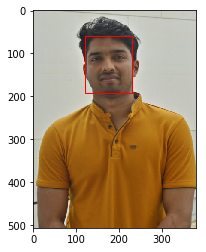

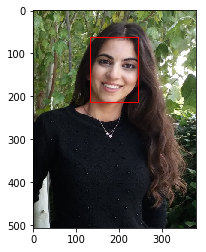

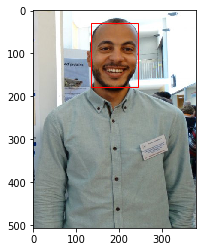

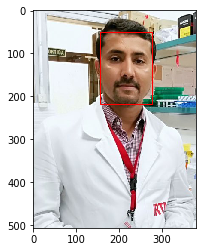

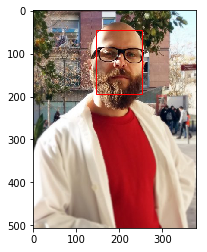

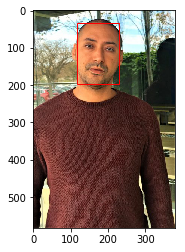

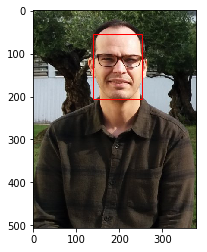

In [93]:
found_faces = []
for imagefile in images_files:
    pixels = plt.imread(imagefile)
    faces = detector.detect_faces(pixels)
    plt.imshow(pixels)
    name = imagefile.split('/')[-1].replace('.jpg','').replace('.JPG','').split('_')
    name = " ".join(list(filter(lambda x: not x.isdigit(),name)))
    for face in faces:
        #x,y,w,d = faces[0]['box']
        x,y,w,d = face['box']
        facex = pixels[y:y+d,x:x+w,:]
        found_faces.append({'name':name,'face':facex.copy()})
        plt.gca().add_patch(
          plt.Rectangle([x,y],w,d,fill=False,color='red',)
          )
    plt.show()

In [94]:
found_faces

[{'face': array([[[52, 47, 53],
          [54, 47, 54],
          [55, 48, 55],
          ...,
          [67, 53, 52],
          [50, 36, 36],
          [32, 18, 18]],
  
         [[58, 51, 58],
          [57, 50, 57],
          [56, 46, 54],
          ...,
          [88, 72, 72],
          [79, 63, 63],
          [51, 37, 36]],
  
         [[60, 53, 60],
          [56, 49, 56],
          [53, 43, 51],
          ...,
          [48, 33, 30],
          [79, 64, 61],
          [76, 62, 61]],
  
         ...,
  
         [[79, 81, 60],
          [88, 89, 73],
          [55, 51, 39],
          ...,
          [78, 58, 51],
          [61, 42, 35],
          [69, 50, 43]],
  
         [[96, 97, 79],
          [88, 86, 73],
          [69, 65, 54],
          ...,
          [79, 59, 52],
          [54, 35, 28],
          [57, 38, 31]],
  
         [[84, 83, 65],
          [82, 80, 68],
          [57, 53, 44],
          ...,
          [69, 50, 43],
          [46, 27, 20],
          [47, 28, 21]]],

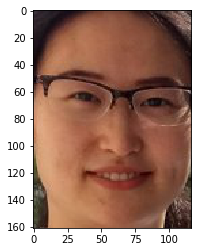

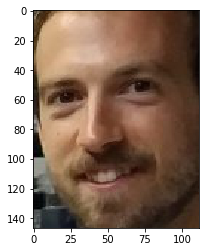

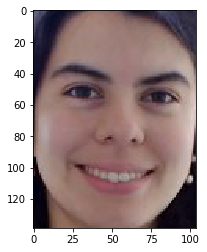

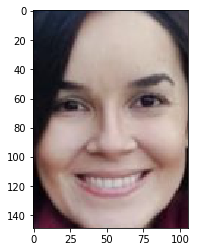

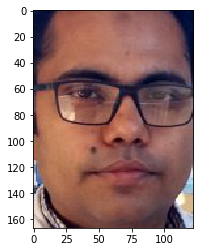

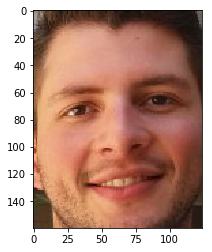

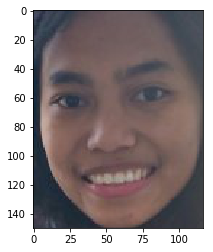

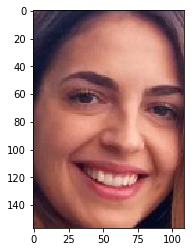

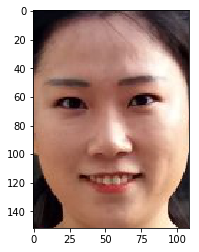

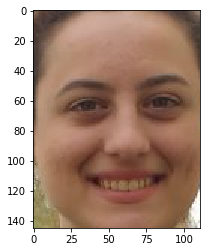

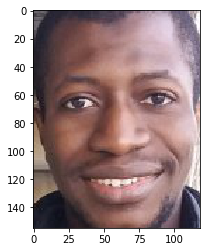

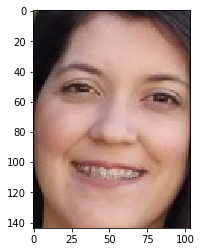

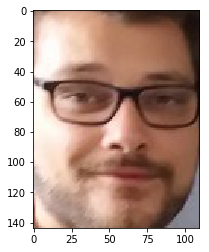

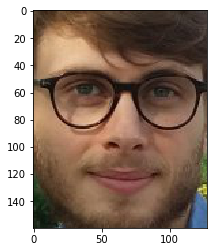

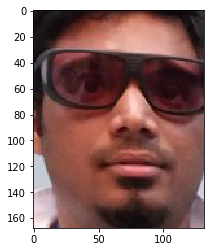

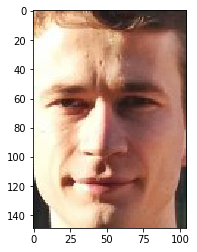

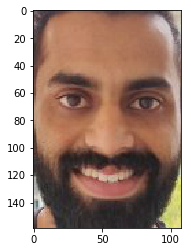

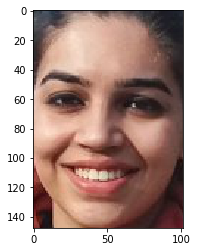

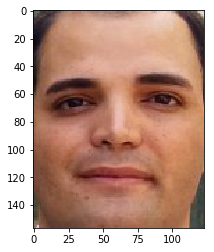

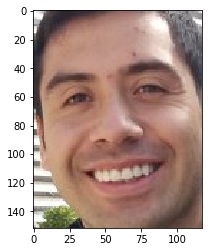

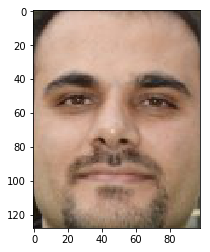

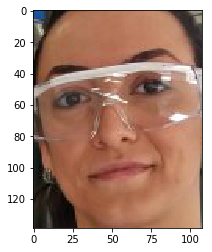

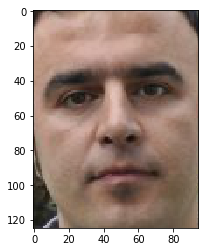

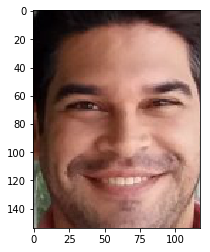

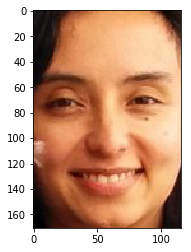

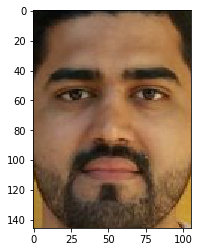

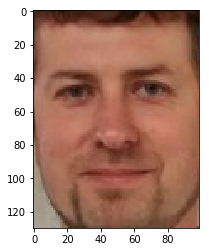

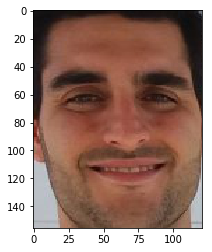

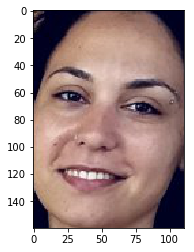

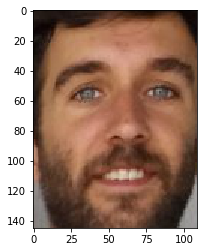

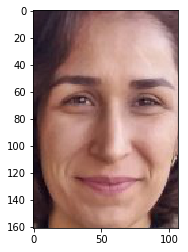

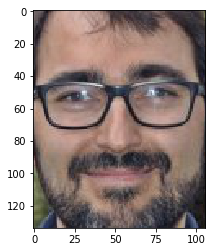

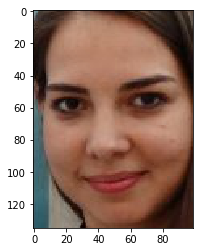

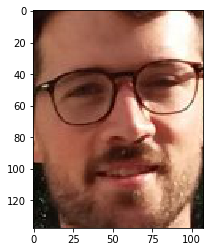

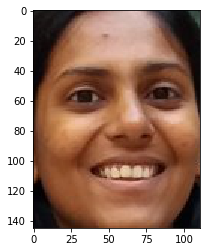

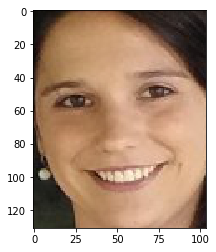

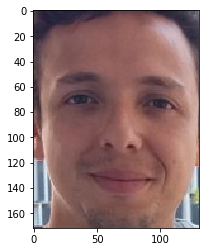

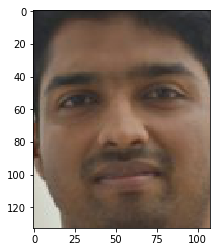

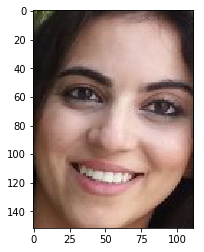

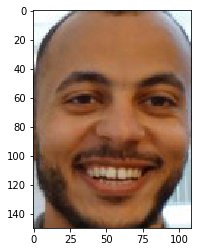

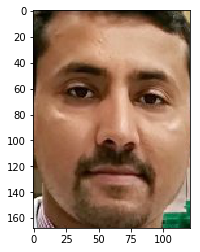

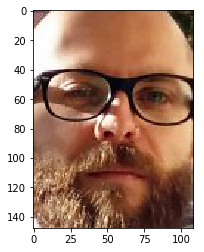

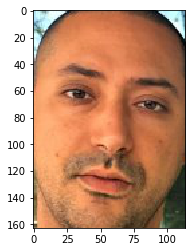

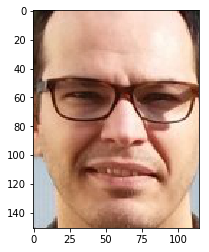

In [95]:
from skimage.transform import rescale, resize, downscale_local_mean

for facei in range(len(found_faces)):
    facex = found_faces[facei]['face']
    if facex.shape[0]>0:
        plt.imshow(facex);plt.show()
        img = resize(facex, (160, 160), anti_aliasing=True)
        img = img.reshape(1,160,160,3).copy()
        found_faces[facei]['representation']=model.predict(img)

In [96]:
print(found_faces[0].keys())
print(found_faces[0]['representation'].shape)

dict_keys(['representation', 'face', 'name'])
(1, 128)


In [98]:
representations = []
for ff in found_faces:
    representations.append(ff['representation'].copy())

representations = np.vstack(representations)
print(representations.shape)

(44, 128)


In [140]:
save_obj(representations,'cofund_representations')
save_obj(found_faces,'cofund_faces')

cofund_representations.pkl saved
cofund_faces.pkl saved


In [141]:
found_faces[0].keys()

dict_keys(['representation', 'face', 'name'])

In [90]:
def save_obj(obj,name):
    import pickle
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        print(name+".pkl saved")

def load_obj(name):
    import pickle
    with open(name, 'rb') as f:
        return pickle.load(f)


def get_representation(inp,min_face_size=20):
    from skimage.transform import rescale, resize, downscale_local_mean
    from mtcnn.mtcnn import MTCNN
    # create the detector, using default weights
    detector = MTCNN(min_face_size=min_face_size)
    # detect faces in the image
    faces = detector.detect_faces(inp)
    if len(faces)<1:
        return None
    output = []
    for face in faces:
        x,y,w,d = face['box']
        facex = inp[y:y+d,x:x+w,:]
        img = resize(facex, (160, 160), anti_aliasing=True)
        img = img.reshape(1,160,160,3).copy()
        representation = model.predict(img)
        pyplot_box = [[x,y],w,d]
        output.append({'box':[y,y+d,x,x+w],'representation':representation.copy(),'pyplot_box':pyplot_box[:]})
    return output[:]

def get_top_similar(irepx,ireprs,faces_db,top=3,):
    distances = abs(irepx-ireprs).sum(1)
    distances_sorted = np.argsort(distances)
    output = []
    for _ in range(top):
        min_index = distances_sorted[_]
        name = faces_db[min_index]['name']
        image = faces_db[min_index]['face']
        output.append({'distance':distances[min_index],'name':name,'image':image.copy()})
    return output[:]



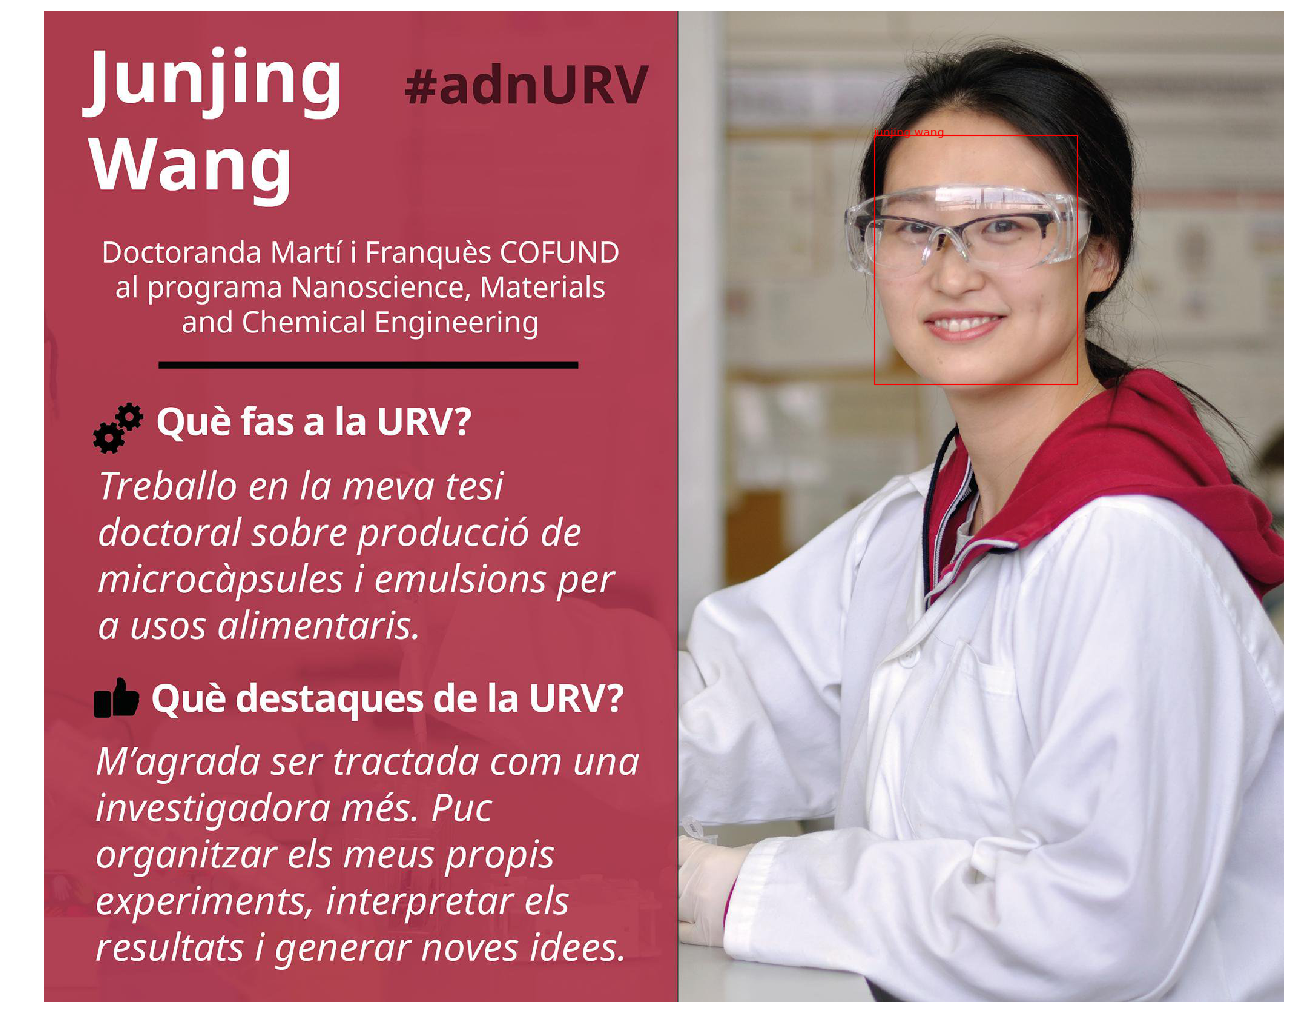

In [136]:
imagefile = 'bsaldivar_400x400.jpg'
imagefile = 'cofunds/valeria_ferreira_1539943360_280.jpg'
imagefile = 'cofunds/all.jpg'
imagefile = 'cofunds/jj.jpg'
pixels = plt.imread(imagefile)
fig = plt.figure(figsize=(20,20),dpi=80,frameon=False)
plt.axis('off')
plt.imshow(pixels)
faces = get_representation(pixels[:,:,:3])
if type(faces)==list:
    for face in faces:
        repx = face['representation'].copy()
        plt.gca().add_patch(
            plt.Rectangle(*face['pyplot_box'],fill=False,color='red',)
          )
        top_images = get_top_similar(repx,representations,found_faces,top=1)
        for found in top_images:
            plt.text(*face['pyplot_box'][0],found['name'],color='red')
plt.show()
fig.savefig('all.png',dpi=80,frameon=False,bbox_inches='tight', pad_inches=0)

In [144]:
def load_image_and_save():
    pixels = plt.imread(imagefile)
    fig = plt.figure(figsize=(20,20),dpi=80,frameon=False)
    plt.axis('off')
    plt.imshow(pixels)
    faces = get_representation(pixels[:,:,:3])
    if type(faces)==list:
        for face in faces:
            repx = face['representation'].copy()
            plt.gca().add_patch(
                plt.Rectangle(*face['pyplot_box'],fill=False,color='red',)
              )
            top_images = get_top_similar(repx,REPRESENTATIONS,FOUND_FACES,top=1)
            for found in top_images:
                plt.text(*face['pyplot_box'][0],found['name'],color='red')
    #plt.show()
    fig.savefig(OUTPUT_IMG,dpi=80,frameon=False,bbox_inches='tight', pad_inches=0)
    plt.close()

SAVE_FOLDER = './'
INPUT_IMG = 'cofunds/jj.jpg'
OUTPUT_IMG = SAVE_FOLDER+'output.png'
imagefile = INPUT_IMG
DB_FOLDER = 'db/'
REPRESENTATIONS = load_obj(DB_FOLDER+'cofund_representations.pkl')
FOUND_FACES = load_obj(DB_FOLDER+'cofund_faces.pkl')
load_image_and_save()






In [121]:
top_images[0]['name']

'valeria ferreira'

In [7]:
"""
print(os.listdir("."))
model_base = keras.models.load_model('facenet_keras.h5')
model_base = keras.models.load_model('facenet_keras_weights.h5')
#No model found in configuration file
"""

'\nprint(os.listdir("."))\nmodel_base = keras.models.load_model(\'facenet_keras.h5\')\nmodel_base = keras.models.load_model(\'facenet_keras_weights.h5\')\n#No model found in configuration file\n'

In [67]:
#https://sefiks.com/2018/09/03/face-recognition-with-facenet-in-keras/
from keras.models import model_from_json
 
#facenet model structure: https://github.com/serengil/tensorflow-101/blob/master/model/facenet_model.json
model = model_from_json(open("facenet_model.json", "r").read())
 
#pre-trained weights https://drive.google.com/file/d/1971Xk5RwedbudGgTIrGAL4F7Aifu7id1/view?usp=sharing
model.load_weights('facenet_weights.h5')
 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

In [6]:
#wget https://raw.githubusercontent.com/serengil/tensorflow-101/master/model/inception_resnet_v1.py
from inception_resnet_v1 import *
model = InceptionResNetV1()

In [8]:
def l2_normalize(x):
 return x / np.sqrt(np.sum(np.multiply(x, x)))

In [9]:
def findEuclideanDistance(source_representation, test_representation):
 euclidean_distance = source_representation - test_representation
 euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
 euclidean_distance = np.sqrt(euclidean_distance)
 return euclidean_distance

In [10]:
from PIL import Image

In [20]:
imgf1  = 'cofund_1_bsaldivar.png'
imgf2  = 'cofund_2_bsaldivar.png'

def open_image_resize(filename):
    img = Image.open(filename)
    img = img.resize((160,160))
    npi = np.asarray(img)
    print(npi.shape)
    img.close()
    npi = npi.reshape(1,160,160,3)
    return npi.copy()

npi1 = open_image_resize(imgf1)
npi2 = open_image_resize(imgf2)

(160, 160, 4)


ValueError: cannot reshape array of size 102400 into shape (1,160,160,3)

In [18]:
#img1_representation = l2_normalize(model.predict(preprocess_image(imgf1))[0,:])
#img2_representation = l2_normalize(model.predict(preprocess_image(imgf2))[0,:])

img1_representation = l2_normalize(model.predict(npi1)[0,:])
img2_representation = l2_normalize(model.predict(npi2)[0,:])
 
euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (160, 160, 4)